In [1]:
#this notebook is based on Igor Halperin's notebook: Trading Strategy based on PCA
#however the notebook has been considerably modified:
#the definition of manual ewma has been changed and all scaling lookahead bias has been eliminated
#both pca signal and trading inputs have been modified for better effect and the KMO statistic is included
#Please install: conda install -c desilinguist factor_analyzer==0.3.2

# Course Personal Project: Trading Strategy based on PCA

**For this assignment you will:**
- Read: https://www.researchgate.net/publication/228140014_Principal_Components_as_a_Measure_of_Systemic_Risk
- Use PCA to calculate a measure of market systemic risk as per this paper.
- Implement and analyze performance of portfolio strategy

**Instructions:**
- conda install -c desilinguist factor_analyzer
- Use vectorization: avoid using for-loops and while-loops, or any "for x in y" syntax unless you are explicitly told to do so.
- After coding your function, run the cell right below it to check if your result is correct.
- When turning in your result include the two .csv files.

The absorption ratio was introduced by Kritzman and others in the 2010 paper, Principal Components as a Measure of Systemic Risk. The authors described the ratio as an implied measure of systemic risk that captures the extent to which markets are unified or tightly coupled.

The basic idea is to use building blocks of sub-assets to see how tightly a system of assets is trading. In this notebook we’ll use U.S. industries as the building blocks to examine the U.S. stock market. More specifically, we’ll examine linear combinations of U.S. industries  that explain the variance of the U.S. stock market. Principal Component Analysis solves this objective iteratively. PCA finds the linear combination of industries that explain the most amount of the market’s variance. Then it finds the next linear combination of industries that explain the most amount of left over variance (that is not explained by the first combination of industries). This process will be repeated until all of the variance has been explained. The absorption ratio gets its name from the idea of calculating how much of the market’s variance is “absorbed” by the first 20% of combinations of industries.

According to the paper, there are two steps to calculating a meaningful absorption ratio (AR). The first is to calculate the AR ratio and the second involves finding the standardized change of the AR ratio over time. The standardized change is essentially a z-score to allow us to detect high outliers of change.

STEP 1: Formally, the ratio is defined by the variance absorbed by the first n eigenvectors:

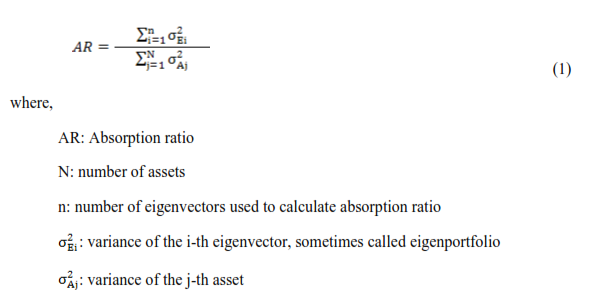

The numerator equals the cumulative portion explained by the first n eigenvectors (i.e. the first n linear combinations of industries). And the denominator equals the total variance explained by all the assets (again, in this case industries). The paper suggests to set n to 1/5 of the total assets. But there are a variety of methods to find the significant stopping point for eigenvectors in PCA. You should try a number of settings for this parameter n. 

 Basically you will see that  first combination (the first eigenvector) of industries explains more than 50% of the total variance. This reading makes sense: the U.S. industries are mostly going to trade together because they’re driven by the same underlying factor, in this case, the market beta which is usually captured by the first eigenvector. The second combination (eigenvector) of industries (possibly representing growth vs value) will add to our explanation of total variance (total risk), and the next one (possibly defensive vs cyclical), etc. until the explained variance is over 80%. This is our absorption ratio. 
Note: the meaning of an eigenvector cannot be determined exactly

STEP 2: Having computed AR daily and put together an AR times series, we further follow M. Kritzman to make use of AR to define yet another measure: AR Delta. AR Delta is the standardized change of the absorption ratio over time. The standardized change is essentially a z-score to allow us to detect high outliers of change In particular:

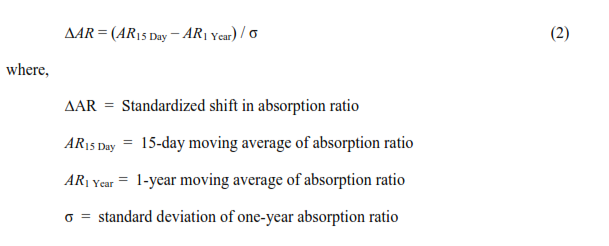

We use  𝐴𝑅 Delta  to build simple portfolio trading strategy.

### Keiser-Meyer-Olkin (KMO)

We have discussed in lecture that PCA can be used to filter "noise" away from data by the removal of some principal components, specifically those that have less importance because their eigenvalue is small compared to that of the principal components that we keep. This presupposes that the the eigenvalues that PCA outputs are NOT all going to be of similar magnitude. If the eigenvalue magnitudes are similar, that is an indication that the variables in the original data were largely uncorrelated with one another to begin with; meaning, each variable was contributing a valuable dimension, so it makes sense to keep all of them, not to get rid of some of them via PCA.  There is a rule of thumb that can be used to determine if PCA is redundant or not: if the average absolute value of the off diagonal elements of the correlation matrix of the orginal data is less than 0.3, then PCA is redundant for that data.  A more formal way making this determination is through the use of the Kaiser-Meyer-Olkin (KMO) measure.

We use the Kaiser-Meyer-Olkin (KMO) measure of sampling adequacy (Kaiser,1970;
Kaiser and Rice,1974) to test the length of the shortest sliding window that a PCA could be
efficiently applied to. The KMO statistic compares the value of correlations between assets
(here industry ETFs) to those of the partial correlations. 
If the investigated assets share more common variation,
the KMO will be close to 1. On the other hand, a KMO near 0 indicates little common variation
and the PCA will not extract much useful information. 

The KMO statistic can also be used to assess the potential for diversification. Since the KMO
statistic measures the degree of common variation among the input assets,
one can expect less diversification opportunities (and higher market risk)
when the assets have more common variation, which means a high KMO test statistic.

As mentioned above, KMO values range between 0 and 1. Value of KMO less than 0.6 is considered inadequate for PCA.

See: 1. Kaiser, H. F. and Rice, J. (1974). Little jiffy. Educational and Psychological Measurement,
34(1):111–117. and 2. https://factor-analyzer.readthedocs.io/en/latest/factor_analyzer.html

In [2]:
import pandas as pd
import numpy as np
import sklearn.decomposition

import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.model_selection
import pandas as pd
from factor_analyzer.factor_analyzer import calculate_kmo

#### Dataset:  daily prices of ETFs of 20 different industries  ####
For this exercise we will be working with 20 ETFs representing 20 different industries. 
The following cell computes returns based on ETF price data. You need to obtain the data from WRDS as follows:

In [3]:
#1. Go to WRDS CRSP database and obtain the price and ticker data for the following industry ETFs:
#    IYW IYJ IBB IGV IXP IYT VNQ PBS PBJ KCE KIE KBE XSD ITB ITA IHI IHF IHE IEZ FDN
#2. set the starting and ending dates as follows: 1/3/2007 and 12/31/2019
#3. Unstack the prices and save the unstacked price data into a csv file called:
#    20industries_ETF_prc_UNSTACKED.csv

In [4]:
import os
# load dataset

asset_prices = pd.read_csv('20industries_ETF_prc_UNSTACKED.csv',
                     date_parser=lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'),
                     index_col = 0).dropna()
n_stocks_show = 20
print('Asset prices shape', asset_prices.shape)
asset_prices.iloc[:, :n_stocks_show].head()

Asset prices shape (3272, 20)


,IYW,IYJ,IBB,IGV,IXP,IYT,VNQ,PBS,PBJ,KCE,KIE,KBE,XSD,ITB,ITA,IHI,IHF,IHE,IEZ,FDN
datadate,,,,,,,,,,,,,,,,,,,,
2007-01-03,54.67,65.36,77.64,44.62,63.70,83.4600,77.12,16.23,16.429,67.6344,57.08,58.63,49.06,41.18,53.48,50.78,53.78,53.3484,43.2000,22.2998
2007-01-04,55.57,65.39,78.84,45.40,64.16,83.8599,77.22,16.33,16.450,67.6500,57.12,58.61,50.11,40.79,53.42,50.94,53.75,53.9000,42.0644,23.2200
2007-01-05,55.12,64.94,78.85,44.99,63.16,82.6100,75.79,16.20,16.350,67.4900,56.66,58.02,49.25,40.38,53.17,50.75,53.35,53.6000,42.0600,22.9900
2007-01-08,55.32,65.15,78.96,45.20,63.75,82.8900,75.90,16.20,16.340,68.6000,56.69,58.17,49.32,39.54,53.76,51.25,53.72,53.6200,42.0899,22.9700
2007-01-09,55.65,65.19,78.91,45.20,63.72,83.1000,76.86,16.23,16.350,68.9100,56.48,58.05,49.56,39.61,53.71,51.58,53.08,53.8700,41.8300,22.9800


### Calculate daily returns

In [5]:
asset_returns = asset_prices.pct_change(periods=1)
asset_returns = asset_returns.iloc[1:, :]
asset_returns.iloc[:, :n_stocks_show].head()

,IYW,IYJ,IBB,IGV,IXP,IYT,VNQ,PBS,PBJ,KCE,KIE,KBE,XSD,ITB,ITA,IHI,IHF,IHE,IEZ,FDN
datadate,,,,,,,,,,,,,,,,,,,,
2007-01-04,0.016462,0.000459,0.015456,0.017481,0.007221,0.004792,0.001297,0.006161,0.001278,0.000231,0.000701,-0.000341,0.021402,-0.009471,-0.001122,0.003151,-0.000558,0.010340,-0.026287,0.041265
2007-01-05,-0.008098,-0.006882,0.000127,-0.009031,-0.015586,-0.014905,-0.018519,-0.007961,-0.006079,-0.002365,-0.008053,-0.010067,-0.017162,-0.010051,-0.004680,-0.003730,-0.007442,-0.005566,-0.000105,-0.009905
2007-01-08,0.003628,0.003234,0.001395,0.004668,0.009341,0.003389,0.001451,0.000000,-0.000612,0.016447,0.000529,0.002585,0.001421,-0.020802,0.011096,0.009852,0.006935,0.000373,0.000711,-0.000870
2007-01-09,0.005965,0.000614,-0.000633,0.000000,-0.000471,0.002533,0.012648,0.001852,0.000612,0.004519,-0.003704,-0.002063,0.004866,0.001770,-0.000930,0.006439,-0.011914,0.004662,-0.006175,0.000435
2007-01-10,0.008985,0.001534,0.004309,0.003540,-0.011142,0.002286,0.012881,0.001232,0.007951,0.015673,0.001239,0.001378,0.017958,0.000505,0.007634,0.002714,0.003391,-0.000371,-0.015061,0.006092


In [6]:
#FILL IN THE MISSING CODE
def normalize_returns(r_df):
    """
    Normalize, i.e. center and divide by standard deviation raw asset returns data

    Arguments:
    r_df -- a pandas.DataFrame of asset returns

    Return:
    normed_df -- normalized returns
    """
    ##FILL IN THE MISSING CODE
    ### START CODE HERE ###
    mean_r =
    sd_r = 
    normed_df = 
    
     ### END CODE HERE ###
    return normed_df

In [7]:
normed_r = normalize_returns(asset_returns)
normed_r.iloc[:, :n_stocks_show].head()

,IYW,IYJ,IBB,IGV,IXP,IYT,VNQ,PBS,PBJ,KCE,KIE,KBE,XSD,ITB,ITA,IHI,IHF,IHE,IEZ,FDN
datadate,,,,,,,,,,,,,,,,,,,,
2007-01-04,1.188124,0.006221,0.793868,1.180974,0.584213,0.290918,0.051180,0.415470,0.101186,0.003972,0.025898,-0.023448,1.050519,-0.432476,-0.124127,0.212696,-0.077886,0.830709,-1.160044,2.666506
2007-01-05,-0.643716,-0.546687,-0.013245,-0.674605,-1.277347,-1.006712,-0.928184,-0.589853,-0.641238,-0.128270,-0.383558,-0.453157,-0.883524,-0.458249,-0.392560,-0.356087,-0.587440,-0.499629,-0.005862,-0.695129
2007-01-08,0.230898,0.215216,0.053529,0.284166,0.757249,0.198545,0.058826,-0.023145,-0.089520,0.830108,0.017885,0.105853,0.048455,-0.935263,0.797693,0.766654,0.476755,-0.002889,0.030086,-0.101553
2007-01-09,0.405192,0.017893,-0.053265,-0.042530,-0.043611,0.142153,0.612228,0.108683,0.033956,0.222439,-0.180146,-0.099524,0.221217,0.066283,-0.109652,0.484508,-0.918438,0.355871,-0.273454,-0.015801
2007-01-10,0.630398,0.087189,0.206939,0.205224,-0.914662,0.125875,0.623711,0.064578,0.774545,0.790663,0.051090,0.052515,0.877783,0.010136,0.536434,0.176604,0.214413,-0.065151,-0.665173,0.355830


#### Part 1 (Implement an exponentially-weighting function to mimic pandas.EWM function)

**Instructions:**
First read: https://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#stats-moments-exponentially-weighted
Next, implement a similar (not exactly identical) function called exponent_weighting which returns a sequence of $w_j$ as np.array. See below:

Define sequence of $X_j$ where $j \subset [0, N]$, an integer taking all values in the interval from 0 to N  $$ X_j =  e^{-\frac{log(2)}{H} \times  \space j}$$
where H is half-life which determines the speed of decay, and $log$ is natural log function.
Then a sequence of exponentially decaying weights $w_j$ is defined as: $$ w_j = \frac{X_j}{ \sum\limits_{i=0}^j X_i } $$

In [8]:
#FILL IN THE MISSING CODE
#Exponent weighting function, to take the place of Pandas EWM function (we will compare their effect)
def exponent_weighting(n_periods, half_life = 252):
    """
    Calculate exponentially smoothed normalized (in probability density function sense) weights

    Arguments:
    n_periods -- number of periods, an integer, N in the formula above
    half_life -- half-life, which determines the speed of decay, h in the formula
    
    Return:
    exp_probs -- exponentially smoothed weights, np.array
    """
    
    exp_probs = np.zeros(n_periods) # do your own calculation instead of dummy zero array
    ##FILL IN THE MISSING CODE
    ### START CODE HERE ### 
    arr=
    num=
    denom=
    exp_probs=
    exp_probs = np.flip(exp_probs)
    ### END CODE HERE ###
    
    return exp_probs
    

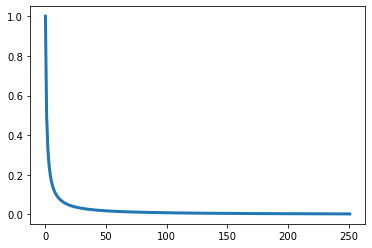

In [9]:
#note the flipping for graphing purposes only, 
#the graph should look like an exponential probability density function
#in reality we want weights applied to returns 
#to decay as returns are older, further in the past
exp_probs = exponent_weighting(252*1)
plt.plot(np.flip(exp_probs), linewidth=3) 

In [10]:
#FILL IN THE MISSING CODE
def absorption_ratio(explained_variance_arr, n_components):
    """
    Calculate absorption ratio via PCA.  
    
    Arguments:
    explained_variance_arr -- 1D np.array of explained variance by each pricincipal component, in descending order
    n_components -- an integer, a number of principal components to compute absorption ratio
    Formally, the ratio is defined by the variance absorbed by the first n eigenvectors
    The numerator equals the cumulative variance explained by the first n eigenvectors (=n_components) 
    And the denominator equals the total variance
    Return:
    ar -- absorption ratio
    """
    ##FILL IN THE MISSING CODE
    ### START CODE HERE ### 
    ar = 
    ### END CODE HERE ### 
    return ar

In [11]:
stock_tickers = asset_returns.columns.values[:]
assert 'SPX' not in stock_tickers, "By accident included SPX index"

half_life = 252             # in (days)
lookback_window = 252 * 1   # in (days)
num_assets = len(stock_tickers)
step_size = 1          # days : 5 - weekly, 21 - monthly, 63 - quarterly

# require 0.8 variance to be explained. How many components are needed?
var_threshold = 0.8     

# fix 20% of principal components for absorption ratio calculation. How much variance (in %) do they explain?
absorb_comp = int((1 / 5) * num_assets)  

print('Half-life = %d' % half_life)
print('Lookback window = %d' % lookback_window)
print('Step size = %d' % step_size)
print('Variance Threshold = ', var_threshold)
print('Number of assets = %d' % num_assets)
print('Number of principal components = %d' % absorb_comp)

Half-life = 252
Lookback window = 252
Step size = 1
Variance Threshold =  0.8
Number of assets = 20
Number of principal components = 4


In [12]:
# indexes date on which to compute PCA
days_offset = 4 * 252 
num_days = 6 * 252 + days_offset 
pca_ts_index = asset_returns.index[list(range(lookback_window + days_offset, min(num_days, len(asset_returns)), step_size))]

# allocate arrays for storing absorption ratio
pca_components = np.array([np.nan]*len(pca_ts_index))
absorp_ratio = np.array([np.nan]*len(pca_ts_index))
kmo = np.array([np.nan]*len(pca_ts_index))

exp_probs = exponent_weighting(lookback_window, half_life)
assert 'SPX' not in asset_returns.iloc[:lookback_window, :].columns.values, "By accident included SPX index"


**Instructions:**
- on each loop iteration: 
    - fit PCA to **cov_mat** or to **ret_frame**
    - use fitted pca model to pass values to absorption_ratio(). 
    - compute number of principal components it takes to explain at least **var_threshold** of variance. The result of this calculation goes into **pca_components[ik]**. The result of the absorption ratio calculation goes into **absorp_ratio[ik]**.  The result of the KMO statistic calculation goes into **kmo[ik]**.

In [13]:
#FILL IN THE MISSING CODE. AFTER YOU HAVE PROGRAMMED THE ENTIRE NOTEBOOK 
#RUN THE LOOP WITH DIFFERENT SETTINGS TO KEEP THE BEST SETTINGS TO MAXIMIZE THE RESULTS OF THE TRADING SYSTEM BASED ON PCA.
# Start with the current setting use_cov_mat = False (input rectangular returns data into PCA) 
# and the current
# ewm = True (you will use exponential weights to multiply the returns instead of equal weights)
#with ewm = True, set:
# manual_ewm = True and run the loop
# manual_ewm = False and run the loop
# Keep the best setting
# Set ewm = False and run the loop (here you will use equal weights to multiply the returns)
# keep the best setting, then
# Set use_cov_mat = True (input square covariance matrix data into PCA)
# keep the best setting

import time

ik = 0
ewm = True # setting ewm to false means historical returns are equally weighted
manual_ewm = True  #use manual ewm (instead of pandas ewm function)
use_cov_mat = False #use the square shaped covariance of ret_frame instead of t ret_frame directly

lin_ae = None
time_start = time.time()
for ix in range(lookback_window + days_offset, min(num_days, len(asset_returns)), step_size):
    ret_frame = normalize_returns(asset_returns.iloc[ix - lookback_window:ix, :]) # fixed window 
    ret_frame_kmo = ret_frame.copy(deep=True)
    if ewm:
        ### START CODE HERE ### 
        if manual_ewm:
            #multiply the returns of ret_frame by the ex_probs (hint:transposing is required more than once)
            #hint: make sure smallest weights multiply the oldest returns
            ret_frame = 
        else:
            ret_frame = ret_frame.ewm(halflife=252).mean() #for comparison
        ### END CODE HERE ### 
        
    cov_mat = ret_frame.cov()
    
    if ik == 0 or ik % 21 == 0:
        #FILL IN THE MISSING CODE
        ### START CODE HERE ### 
        ### fit PCA, compute the pca components and absorption ratio 
        ### store results into pca_components[ik] and absorp_ratio[ik]
        #instantiate pca object
        pca = sklearn.decomposition.PCA()
        if use_cov_mat:
            #fit pca to cov_mat
            
        else:
            #fit pca to ret_frame
            
            
        #Using ret_frame_kmo, calculate the KMO statistic (=kmo_total) and assign it to kmo[ik]. 
        kmo_per_variable, kmo_total=
        kmo[ik] = 
        #calculate the number of components needed to explain the var_threshold and assign it to pca_components[ik] (2 lines)
        explained_variance = 
        pca_components[ik] = 
        #calculate the absorption ratio by calling absorption_ratio() and assign it to absorp_ratio[ik]
        #when you run this loop try various settings for the parameter n_components in this absorption_ratio function.
        absorp_ratio[ik] = 
        ### END CODE HERE ###
    else:
        absorp_ratio[ik] = absorp_ratio[ik-1] 
        pca_components[ik] = pca_components[ik-1]
        kmo[ik] = kmo[ik-1]

    ik += 1
    
print ('Absorption Ratio done! Time elapsed: {} seconds'.format(time.time() - time_start))    
ts_pca_components = pd.Series(pca_components, index=pca_ts_index)
ts_absorb_ratio = pd.Series(absorp_ratio, index=pca_ts_index)

C:\Users\loren\anaconda3\envs\py37\lib\site-packages\factor_analyzer\utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '
C:\Users\loren\anaconda3\envs\py37\lib\site-packages\factor_analyzer\utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '
C:\Users\loren\anaconda3\envs\py37\lib\site-packages\factor_analyzer\utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '
C:\User

Absorption Ratio done! Time elapsed: 4.0299742221832275 seconds


C:\Users\loren\anaconda3\envs\py37\lib\site-packages\factor_analyzer\utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


The value of the KMO statistic should be between .6 and 1. Change the number of years (with a year defined in terms of 252 trading days) in the lookback window to get the minimum KMO below to be close to 0.944286628546701. The KMO statistic and AR tell us similar information:

In [14]:
np.amin(kmo)

0.944286628546701

<AxesSubplot:>

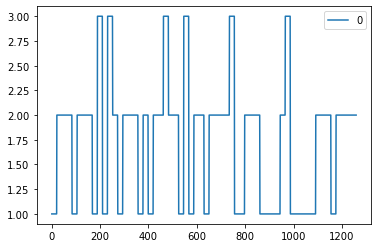

In [15]:
pd.DataFrame(pca_components).plot()

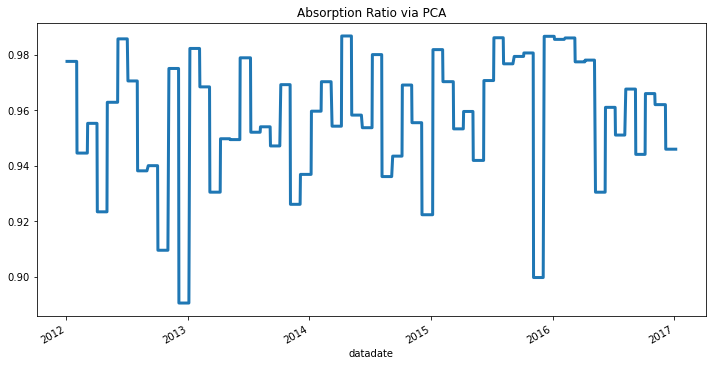

In [16]:
ts_absorb_ratio.plot(figsize=(12,6), title='Absorption Ratio via PCA', linewidth=3)
plt.savefig("Absorption_Ratio_20i.png", dpi=900)

STEP 2:
Having computed the Absorption Ratio as a daily times series, we define AR Delta. AR Delta is the standardized change of the absorption ratio over time. The standardized change is essentially a z-score to allow us to detect high outliers of change
In particular:
$$ AR\delta = \frac{AR_{15d} - AR_{1y}}{ AR\sigma_{1y}}$$
We use  $AR\delta$ to build simple portfolio trading strategy

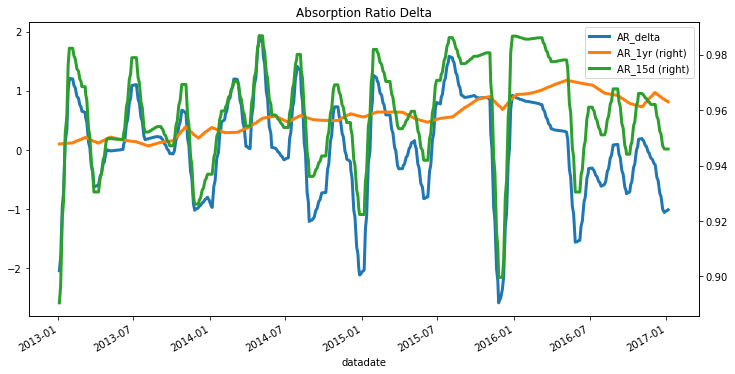

In [17]:
# following Kritzman and computing AR_delta = (15d_AR -1yr_AR) / sigma_AR
ts_ar = ts_absorb_ratio
ar_mean_1yr = ts_ar.rolling(252).mean()
ar_mean_15d = ts_ar.rolling(15).mean()
ar_sd_1yr = ts_ar.rolling(252).std()
ar_delta = (ar_mean_15d - ar_mean_1yr) / ar_sd_1yr  # standardized shift in absorption ratio

df_plot = pd.DataFrame({'AR_delta': ar_delta.values, 'AR_1yr': ar_mean_1yr.values, 'AR_15d': ar_mean_15d.values}, 
                       index=ts_ar.index)
df_plot = df_plot.dropna()
if df_plot.shape[0] > 0:
    df_plot.plot(figsize=(12, 6), title='Absorption Ratio Delta', linewidth=3, secondary_y=['AR_1yr','AR_15d'])

#### Part 3 (AR Delta Trading Strategy)

**Instructions:** Implement get_weight() function

The AR Delta trading strategy forms a portfolio of EQ (equities=stocks) and FI (fixed income=bonds), following these simple rules:

* __$ -1\sigma < AR < +1\sigma $__	 50% / 50% weights for EQ / FI
* __$ AR > +1\sigma $__	             0% / 100% weights for EQ / FI
* __$ AR < -1\sigma $__	             100% / 0% weights for EQ / FI

Here we compute AR Delta strategy weights using data from the same data set. As expected, the average number of trades per year is very low.

In [18]:
#FILL IN THE MISSING CODE
def get_weight(ar_delta):
    '''
    Calculate EQuity / FIncome portfolio weights based on Absorption Ratio delta
    Arguments:
    ar_delta -- Absorption Ratio delta
    
    Return: 
        wgts -- a vector of portfolio weights
    '''
    #FILL IN THE MISSING CODE
    ### START CODE HERE ### 
    
    wgts = [0.0, 0.0] # replace with your own calculation here
    if ar_delta < -1:
        wgts =
    elif ar_delta > 1:
        wgts = 
    else:
        wgts =
    return wgts
    ### END CODE HERE ###

In [19]:
#Average trades per year
ar_delta_data = ar_delta[251:]

rebal_dates = np.zeros(len(ar_delta_data))
wgts = pd.DataFrame(data=np.zeros((len(ar_delta_data.index), 2)), index=ar_delta_data.index, columns=('EQ', 'FI'))

prtf_wgts = get_weight(ar_delta_data.values[0])
wgts.iloc[0, :] = prtf_wgts
for ix in range(1, len(ar_delta_data)):
    prtf_wgts = get_weight(ar_delta_data.values[ix])
    wgts.iloc[ix, :] = prtf_wgts
    if wgts.iloc[ix-1, :][0] != prtf_wgts[0]:
        prtf_wgts = wgts.iloc[ix, :]
        rebal_dates[ix] = 1

ts_rebal_dates = pd.Series(rebal_dates, index=ar_delta_data.index)
ts_trades_per_year = ts_rebal_dates.groupby([ts_rebal_dates.index.year]).sum()
print('Average number of trades per year %.2f' % ts_trades_per_year.mean())

Average number of trades per year 5.20


Now that weights have been determined, run the re-balancing strategy using time series of returns and compute
 - sharpe of the strategy
 - strategy annualized return
 - strategy annualized volatility

Contrast this with 50 / 50 Equity / Fixed Income ETF strategy performance using the same performance metrics. Use VTI as Equity and AGG as Fixed Income assets.

In [20]:
#1. Go to WRDS CRSP database and obtain the Holding Period Return and ticker for the following industry ETFs:
#    VTI AGG
#the holding period return includes dividends, coupon flows etc.
#2. set the starting and ending dates as follows: 1/3/2007 and 12/31/2019
#3. Unstack the holding period returns and save the unstacked returns data into a csv file called:
#    AGG_VTI_UNSTACKED_adjusted_returns.csv

In [21]:
#These are adjusted PERCENT returns of AGG and VTI from WRDS CRSP, including distibutions, coupons, dividends etc.
etf_percent_returns = pd.read_csv('AGG_VTI_UNSTACKED_adjusted_returns.csv')
etf_percent_returns["datadate"]=pd.to_datetime(etf_percent_returns['datadate'])
etf_percent_returns.set_index(['datadate'], inplace=True)
#Use the adjusted PERCENT returns to calculate the etf_log returns:
etf_log_returns = 
#decide which return you are going to use by uncommenting a or b below (only a or b is correct, not both):
#a:
#etf_returns = etf_log_returns.copy()
#b:
#etf_returns = etf_percent_returns.copy()

In [22]:
n_stocks_show = 2
print('Asset holding period returns shape', etf_returns.shape)
etf_returns.iloc[:, :n_stocks_show].head()

Asset holding period returns shape (3271, 2)


,AGG,VTI
datadate,,
2007-01-03,0.002106,-0.001854
2007-01-04,0.002102,0.002001
2007-01-05,-0.000699,-0.007916
2007-01-08,0.000600,0.003666
2007-01-09,0.000000,0.000000


#### Part 4 (Calculate performance of backtested strategy)

**Instructions:**

Implement function backtest_strategy which given a DataFrame of strategy weights and a DataFrame asset returns annualized return, volatility and Sharpe ratio of a strategy. about the equity curve at the end of the absorption ratio project:
The final equity curve and metrics you get may differ from the one pre-existing on the notebook (we will not penalize you for a small difference). But you ought to be able to get a solution that has a shape ratio above 1 and the absorption ratio portfolio beats the equally weighted portfolio.

In [23]:
#FILL IN THE MISSING CODE
def backtest_strategy(strat_wgts, asset_returns, periods_per_year = 252):
    '''
    Calculate portfolio returns and return portfolio strategy performance
    Arguments:
    
    strat_wgts -- pandas.DataFrame of weights of the assets
    asset_returns -- pandas.DataFrame of asset returns
    periods_per_year -- number of return observations per year
    
    Return: 
        (ann_ret, ann_vol, sharpe) -- a tuple of (annualized return, annualized volatility, sharpe ratio)
    before returning plot the cumulative return of the EWM+AGG portfolio  
    '''
    #FILL IN THE MISSING CODE
    ### START CODE HERE ### (≈ 10 lines of code)
    df_all=pd.merge(strat_wgts,asset_returns, left_index=True, right_index=True, how='inner')
    df_all['EQ_part'] = 
    df_all['FI_part'] = 
    df_all['PORT_ret']=
    annualized_return=
    annualized_vol = 
    annualized_sharpe = 
    #before returning plot the cumulative return of the EWM+AGG portfolio 


    df_all['Cum_PORT_ret'].plot()
    ### END CODE HERE ###
    return annualized_return, annualized_vol, annualized_sharpe
   

Absorption Ratio strategy: 0.08851980773042617 1.1019366264217738 1.2752170591795082
Equally weighted: 0.07901199008919721 1.0200200060290971 1.229658683943613


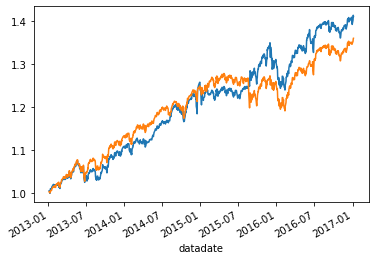

In [24]:
ann_ret, ann_vol, sharpe = backtest_strategy(wgts, etf_returns)
print('Absorption Ratio strategy:', ann_ret, ann_vol, sharpe)

eq_wgts = wgts.copy()
eq_wgts.iloc[:, ] = 0.5
ann_ret_eq_wgt, ann_vol_eq_wgt, sharpe_eq_wgt = backtest_strategy(eq_wgts, etf_returns)
print('Equally weighted:', ann_ret_eq_wgt, ann_vol_eq_wgt, sharpe_eq_wgt)

#NOTE: THE GRAPH AND RESULTS BELOW ARE ONLY APPROXIMATE